<a href="https://colab.research.google.com/github/AmitNG2000/AWS-Cloud-Computing/blob/master/code/Topic_Clustring_and_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalations and Imports

In [91]:
!pip install bertopic
!pip install tweet-preprocessor
!pip install spacy-entity-linker
!pip install emoji

In [92]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt

import re
import emoji

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

import spacy

# Load Data

## Connect to Goole Drive


In [93]:
# Connect to Goole Drive to use the data.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Labeled Datasets for Research on Information Operations.

In [94]:
file_path = "/content/drive/Shareddrives/KeyBoostAuthor/Labeled_Datasets/Ecuador/Ecuador_part_3.gzip.parquet"

df = pd.read_parquet(file_path)

In [95]:
df.head()

,postid,post_text,application_name,post_language,in_reply_to_postid,in_reply_to_accountid,post_time,accountid,account_profile_description,follower_count,following_count,account_creation_date,is_repost,reposted_accountid,reposted_postid,hashtags,urls,account_mentions,is_control
100000,43394c24c54037f763e8318026ffba9aeb9317f672,"Queda prohibido no sonreir a los problemas, no...",2727201c363b6fc4afe259ba4094ae0c49cb4df224,None,None,None,2013-02-21 16:02:00,71cc57155d061d447c2c65756c7dfd6873e403a097,🍃🧚‍♀️🧜‍♀️👑,3618,2055,2009-12-22,True,5ff80261b935621244fb38fff05231bf108ba8a488,4af2ce0fdafbc22f1a0be317a2f1025f2b18983194,[],[],[5ff80261b935621244fb38fff05231bf108ba8a488],False
100001,1b6cb8bafe65e8b9e639b7e52075c8ebf34d854d6c,"Te encontraras con gente hipócrita, con amigos...",62010408238d4a0f958ec97eec3db0a4f69bcd0d11,es,None,None,2013-02-21 16:04:04,8949eab1b3f746ed66a069ae5d6c415a57dc546ffc,Agradecida con Dios y con la Vida. Ahora en #...,471,233,2010-08-25,False,None,None,[],[],[],True
100002,4b69e40a8e23031f7ddc3832dfe5f289e851b56299,Aventarle un diccionario a alguien en la cabez...,62010408238d4a0f958ec97eec3db0a4f69bcd0d11,es,None,None,2013-02-21 16:04:12,8949eab1b3f746ed66a069ae5d6c415a57dc546ffc,Agradecida con Dios y con la Vida. Ahora en #...,471,233,2010-08-25,False,None,None,[],[],[],True
100003,f810b69a925e539fb18b86ad0d227751cf072738bd,"Suena mi alarma del celu, tendre que levantarm...",62010408238d4a0f958ec97eec3db0a4f69bcd0d11,es,None,None,2013-02-21 16:04:16,8949eab1b3f746ed66a069ae5d6c415a57dc546ffc,Agradecida con Dios y con la Vida. Ahora en #...,471,233,2010-08-25,True,7e6b7dd1aa865b143fc37f4181e392613d1e6dfe3f,e6e93d6dcfdca0ea6ba2104dc6532ade3f85263147,[],[],[7e6b7dd1aa865b143fc37f4181e392613d1e6dfe3f],True
100004,94e00228f2ac99ef8ae06ab1c5419e74dfd7dc4699,En el mar la vida es mas sabrosa 8' @5b3c3e3a2...,e278f5ccf53957cccf9e97b2ae3fec72d5b892f850,None,None,None,2013-02-21 16:15:00,4a08f9f3e1b73d62e982f899cdfb644e2101bd28a4,Grateful💕,587,270,2010-06-06,True,ad1f5918aa283b31785d589c2ade1c1ca176a23a47,4e9a2c4ec3f5bb6ec24e2936e287ac2fa33b30245d,[],[https://f87702c9a584719155693093bf96b50d218e8...,"[ad1f5918aa283b31785d589c2ade1c1ca176a23a47, 5...",False


## Dataset Statistics

In [96]:
total_posts = len(df)
hashtag_posts = df[df['hashtags'].notna() & (df['hashtags'].str.len() > 0)]
mention_posts = df[df['account_mentions'].notna() & (df['account_mentions'].str.len() > 0)]
url_posts = df[df['urls'].notna() & (df['urls'].str.len() > 0)]

print(f"{'df shape:':<40} {df.shape}")
print(f"{'df posts with hashtags # shape:':<40} {hashtag_posts.shape}  ({len(hashtag_posts)/total_posts*100:.2f}%)")
print(f"{'df posts with account_mentions @ shape:':<40} {mention_posts.shape}  ({len(mention_posts)/total_posts*100:.2f}%)")
print(f"{'df posts with urls shape:':<40} {url_posts.shape}  ({len(url_posts)/total_posts*100:.2f}%)")


print()
print()

print(f"{'**collum name**':<30} **value type**")
for col in df.columns:
    dtype_str = str(df[col].dtype)  # Convert dtype to string
    # get a sample non-null value if exists
    sample_val = df[col].dropna().iloc[0] if df[col].notna().any() else None
    print(f"{col:<30} | {type(sample_val).__name__}")


print()
print()
print(df['post_language'].value_counts().head())

df shape:                                (50000, 19)
df posts with hashtags # shape:          (22419, 19)  (44.84%)
df posts with account_mentions @ shape:  (31089, 19)  (62.18%)
df posts with urls shape:                (18968, 19)  (37.94%)


**collum name**                **value type**
postid                         | str
post_text                      | str
application_name               | str
post_language                  | str
in_reply_to_postid             | str
in_reply_to_accountid          | str
post_time                      | Timestamp
accountid                      | str
account_profile_description    | str
follower_count                 | int64
following_count                | int64
account_creation_date          | date
is_repost                      | bool
reposted_accountid             | str
reposted_postid                | str
hashtags                       | ndarray
urls                           | ndarray
account_mentions               | ndarray
is_control          

# Clean Text

In [97]:
def clean_url(url_match):

    url = url_match.group(0)

    # 1. Remove protocol (http:// or https://)
    url = re.sub(r"^https?://", "", url)
    url = re.sub(r"^www\.", "", url)

    # 2. Remove query parameters (?x=1)
    url = url.split("?")[0]

    # 3. Split into components by "/"
    parts = url.split("/")

    # Domain (first part)
    domain = parts[0].replace(".", "_")  # twitter.com → twitter_com

    # First section (second part of the URL)
    if len(parts) > 1 and parts[1].strip() != "":
        section = parts[1].replace(".", "_")
        token = f" URL_{domain}_{section} "
    else:
        token = f" URL_{domain} "

    return token


In [98]:
def clean_text(text: str) -> str:

    # lowercase
    text = str(text).lower()

    # URLs → domian + first section
    text = re.sub(r"https?://\S+|www\.\S+", clean_url, text)

    # Hashtags → HASHTAG_xxx
    text = re.sub(r"#(\w+)", r" HASHTAG_\1 ", text)

    # Mentions → MENTION_xxx
    text = re.sub(r"@(\w+)", r" MENTION_\1 ", text)

    # emoji → EMOJI_xxx
    text = emoji.demojize(text, delimiters=(" EMOJI_", " "))

    # Collapse spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [99]:
df["clean_post_text"] = df["post_text"].apply(clean_text)

## Remove Engllish Stopwords

In [100]:
from nltk.corpus import stopwords
import nltk

In [101]:
nltk.download('stopwords')

EXTRA_STOPWORDS = [
    'he', 'she', 'they', 'you', 'i', 'we', 'im', 'hes', 'shes', 'its', 'rt', 'amp', 're',
    'theyre', 'dont', 'doesnt', 'would', 'could', 'like', 'know', 'say', 'said', 'one',
    'look', 'looks', 'think', 'oh', 'yeah', 'guy', 'gonna', 'thing', 'someone', 'people',
    'get', 'got', 'thats', 'just', 'really', 'even', 'still', 'want', 'need', 'needs',
    'me', 'to', 'you', 'the', 'that', 'be', 'my', 'get', 'in', 'and',
     'rt', 'the', 'https', 'to', 'my', 'it', 'on', 'you', 'of', 'for', 'https', 'http', 'RT'
]
all_stopwords_english = set(stopwords.words('english') + EXTRA_STOPWORDS)

def remove_stopwords(text):
    return " ".join([w for w in text.split() if w not in all_stopwords_english])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
df["clean_post_text"] = df["post_text"].apply(remove_stopwords)

In [103]:
df[["post_text", "clean_post_text"]].head(20)

,post_text,clean_post_text
100000,"Queda prohibido no sonreir a los problemas, no...","Queda prohibido sonreir los problemas, luchar ..."
100001,"Te encontraras con gente hipócrita, con amigos...","Te encontraras con gente hipócrita, con amigos..."
100002,Aventarle un diccionario a alguien en la cabez...,Aventarle un diccionario alguien en la cabeza ...
100003,"Suena mi alarma del celu, tendre que levantarm...","Suena mi alarma del celu, tendre que levantarm..."
100004,En el mar la vida es mas sabrosa 8' @5b3c3e3a2...,En el mar la vida es mas sabrosa 8' @5b3c3e3a2...
100005,"—Abue, ¿por qué tienes la boca tan grande? —Tú...","—Abue, ¿por qué tienes la boca tan grande? —Tú..."
100006,Ver fotos del pasado.. recordar y llorar por e...,Ver fotos del pasado.. recordar llorar por esa...
100007,@597739f6dae7bf858889e6e3d126ae99e935ee9415 ja...,@597739f6dae7bf858889e6e3d126ae99e935ee9415 ja...
100008,Tengo mi sonrisa lista para cuando te vea.,Tengo mi sonrisa lista para cuando te vea.
100009,"Si quieres saber donde está tu corazón, mira d...","Si quieres saber donde está tu corazón, mira d..."


# **English** Topic Clustering

In [104]:
# For Testing Only
df = df[df["post_language"] == "en"].head(200).copy()
print(f"english_df shape: {df.shape}")

english_df shape: (200, 20)


In [105]:
def english_topic_modeling(posts_text_lst, min_topic_size=10):

    embedding_model = SentenceTransformer("digio/Twitter4SSE")

    topic_model = BERTopic(
        embedding_model=embedding_model,
        language="english",
        min_topic_size=min_topic_size,
        verbose=True
    )

    topics, probs = topic_model.fit_transform(posts_text_lst)

    return topics, probs, topic_model

In [106]:
posts_text_lst = df["clean_post_text"].to_list()

topics, probs, topic_model = english_topic_modeling(posts_text_lst)

df["topic"] = topics

2025-11-16 12:36:02,745 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2025-11-16 12:38:20,467 - BERTopic - Embedding - Completed ✓
2025-11-16 12:38:20,468 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-16 12:38:21,107 - BERTopic - Dimensionality - Completed ✓
2025-11-16 12:38:21,110 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-16 12:38:21,138 - BERTopic - Cluster - Completed ✓
2025-11-16 12:38:21,145 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-16 12:38:21,170 - BERTopic - Representation - Completed ✓


In [107]:
topic_count = topic_model.get_topic_info()
topic_count

,Topic,Count,Name,Representation,Representative_Docs
0,0,87,0_https_it_f82a72e78fbfe0c50f93a4f39249328c618...,"[https, it, f82a72e78fbfe0c50f93a4f39249328c61...",[@bb046ce8e8d47d6781f04b9c78930646819ee9b35d l...
1,1,86,1_that_me_shit_you,"[that, me, shit, you, cant, __, care, but, day...",[I Agree . Personality Over Looks . BUT You Ca...
2,2,14,2_cancer_03d691699fd4508b58fd930f2e8e8b17f6352...,"[cancer, 03d691699fd4508b58fd930f2e8e8b17f6352...",[“@03d691699fd4508b58fd930f2e8e8b17f6352591e2:...
3,3,13,3_meirc_training_dubai_uae,"[meirc, training, dubai, uae, https, managemen...",[Establishing Managing Project Management Offi...


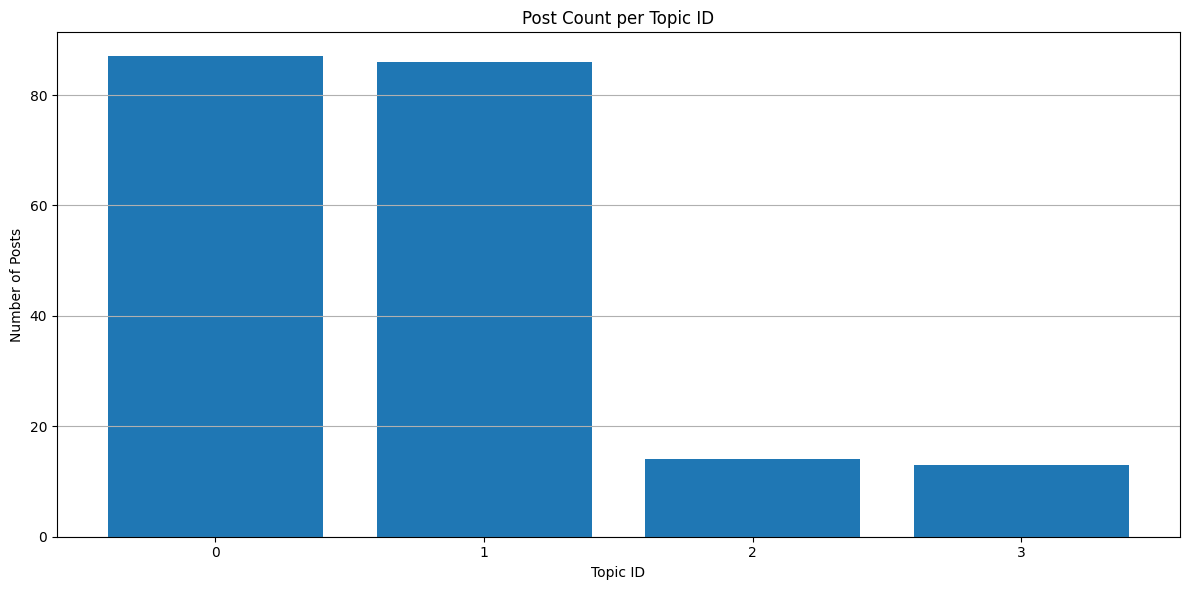

In [108]:
plt.figure(figsize=(12, 6))
plt.bar(topic_count.Topic, topic_count.Count)
plt.xlabel("Topic ID")
plt.ylabel("Number of Posts")
plt.title("Post Count per Topic ID")
plt.grid(axis='y')
plt.xticks(topic_count.Topic)
plt.tight_layout()
plt.show()

In [109]:
topic_model.visualize_topics(custom_labels=True)

In [110]:
topic_model.visualize_hierarchy()

# Named Entity Recognition (NER)

In [111]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load model ONCE
tokenizer = AutoTokenizer.from_pretrained("TweebankNLP/bertweet-tb2_wnut17-ner")
model = AutoModelForTokenClassification.from_pretrained("TweebankNLP/bertweet-tb2_wnut17-ner")

ner_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

def extract_ner_entities(text):
      entities = ner_pipeline(text)
      return [ent["word"] for ent in entities]

Device set to use cpu


In [112]:
df["ner_entities"] = df["clean_post_text"].apply(extract_ner_entities)

In [113]:
df[["clean_post_text", "ner_entities"]].head(20)

,clean_post_text,ner_entities
100031,@72c233209dc9fa95258de4150952791cc619e258cc ch...,[]
100032,White Stripes! https://e41b04e5a81c5f08e7ff672...,[]
100148,To keep just...,[]
100187,Lost insecure found me..,[]
100191,beautiful diamonds sky,[]
100192,tonight I :),[]
100193,eye eye,[]
100194,diamonds :),[]
100196,shine bright night I,[]
100197,Today stats: new unfollower via https://ae0dbe...,[]


# Save to parquet

In [114]:
from pathlib import Path

file_name = Path(file_path).name

# Create new filename
# output_path = str(Path(file_path).with_name(f"{base_name}_with_topic_and_ner.gzip.parquet"))

df.to_parquet(file_name, compression="gzip", index=False)